# Dataset

In [5]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

print("Dataset size: ", len(words))
print("Smallest length: ", min(len(w) for w in words))
print("Largest length: ", max(len(w) for w in words))
print("Examples: ", words[:10])

Dataset size:  32033
Smallest length:  2
Largest length:  15
Examples:  ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


# Examining & Counting Bigrams

In [6]:
freq: dict[tuple[str, str], int] = {}
# Create bigrams of individual character pairs, including start and end. Keep
# statistics about likelihood of pairs of one character following another
for w in words:
    chs = ['<S>']  + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        freq[bigram] = freq.get(bigram, 0) + 1

In [7]:
most_common = list(freq.items())
most_common.sort(reverse=True, key=lambda kv: kv[1])
most_common[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

# Count bigrams using Torch Tensors

In [31]:
import torch

# Use tensors to capture the frequency of bigrams. First lets determine the characters
# in the dataset used as offsets within the tensor.

START = '<S>'
END = '<E>'

chars = sorted(list(set(''.join(words))))
stoi = { s: i for i, s in enumerate(chars) }
stoi[START] = 26
stoi[END] = 27
itos = { i: s for s, i in stoi.items() }

N = torch.zeros(len(stoi), len(stoi), dtype=torch.int32)
for w in words:
    chs = [START]  + list(w) + [END]
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] +=1

(-0.5, 27.5, 27.5, -0.5)

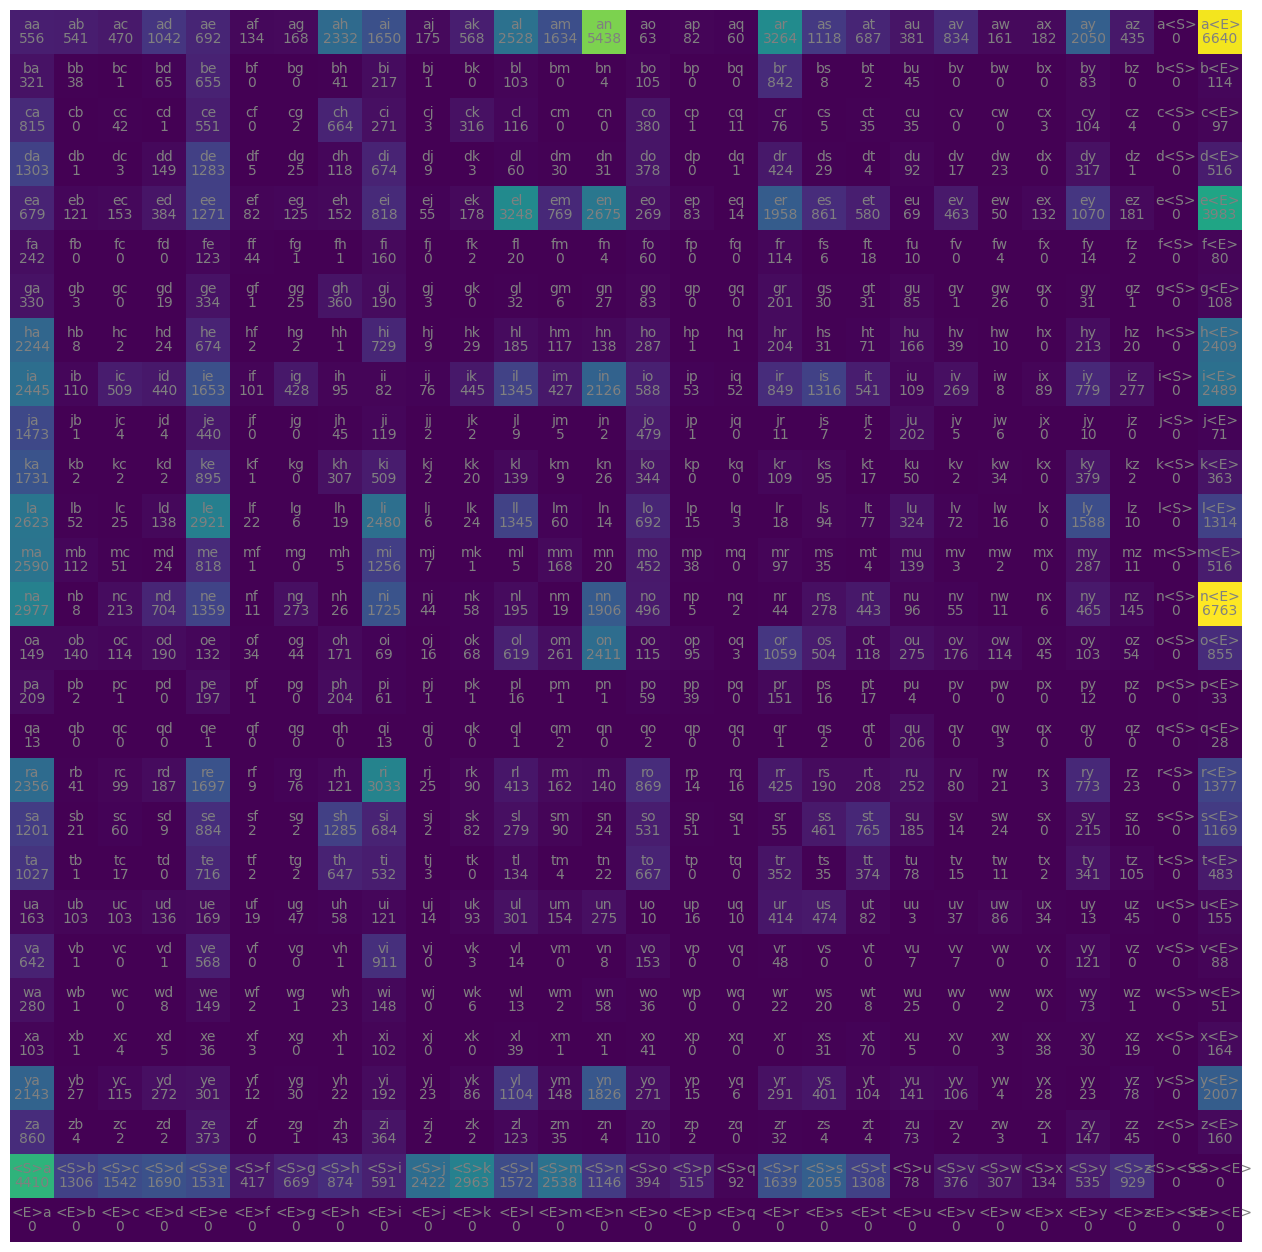

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N)
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis('off')